In [553]:

from ctypes import *
from dwfconstants import *
import time
import sys

In [554]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['resize', 'hist', 'datetime', 'cast']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [557]:
# Initialization of Digilent Analog Discovery 2 
dwf = cdll.dwf
hdwf = c_int()
version = create_string_buffer(16)
dwf.FDwfGetVersion(version)
print("DWF Version: "+str(version.value))

print("Opening first device")
hdwf = c_int()
dwf.FDwfDeviceOpen(c_int(-1), byref(hdwf))

if hdwf.value == 0:
    print("failed to open device")
    szerr = create_string_buffer(512)
    dwf.FDwfGetLastErrorMsg(szerr)
    print(str(szerr.value))
    quit()

DWF Version: b'3.18.1'
Opening first device


## apply +/-5 V bias voltage to the microwave switch 

In [558]:
# set up analog IO channel nodes
# enable positive supply
dwf.FDwfAnalogIOChannelNodeSet(hdwf, c_int(0), c_int(0), c_double(True)) 
# set voltage to 5 V
dwf.FDwfAnalogIOChannelNodeSet(hdwf, c_int(0), c_int(1), c_double(5.0)) 
# enable negative supply
dwf.FDwfAnalogIOChannelNodeSet(hdwf, c_int(1), c_int(0), c_double(True)) 
# set voltage to -5 V
dwf.FDwfAnalogIOChannelNodeSet(hdwf, c_int(1), c_int(1), c_double(-5.0)) 

1

In [559]:
dwf.FDwfAnalogIOEnableSet(hdwf, c_int(True))

1

## Pulse design

Digilent Analog Discovery 2 DO channels:

- Ch 0: green AOM
- Ch 1: MW 
- Ch 2: AWG
- Ch 3: Swabian ch3
- Ch 4: Swabian ch4

- Ch 7: monitor

In [560]:
# create arrays for the DO channel outputs, 1 for TTL high and 0 for TTL low on each channel
class pulse_designer():
    def __init__(self, channel_list, res = 10e-9):
        self.pulse = []
#         Initialize empty lists for all 16 channels
        for i in range(16):
            self.pulse.append([])
            
        self.channel_list = channel_list
        self.res = res    # time resolution
        
    def add_pulse(self, idxChannels, pulse_width):
        pulse_points = int(pulse_width/self.res)
        other_channels = self.channel_list[:]
        
        for i in idxChannels:
            self.pulse[i] += [1] * pulse_points
            other_channels.pop(other_channels.index(i))
        
        for i in other_channels:
            self.pulse[i] += [0] * pulse_points
        
    def plot_pulse_pattern(self):
        total_pulse_points = len(self.pulse[self.channel_list[0]])
        time_array = linspace(0, total_pulse_points*self.res, total_pulse_points)
        figure()
        for i in self.channel_list:
            plot(time_array, self.pulse[i], label='Ch: %d'%i)
        legend()
        
    def get_total_length(self):
        total_points = len(self.pulse[self.channel_list[0]])
        return total_points*self.res

## configure Digital Output channels

In [561]:
def Configure_DO_channel(device_handle, idxChannel, data):
    
#     # get internal clock frequency
#     internal_frequency = c_double()
#     dwf.FDwfDigitalOutInternalClockInfo(device_handle, byref(internal_frequency))
    
    # enable the respective channel
    dwf.FDwfDigitalOutEnableSet(device_handle, c_int(idxChannel), c_int(1))
    # set output type
    dwf.FDwfDigitalOutTypeSet(device_handle, c_int(idxChannel), DwfDigitalOutTypeCustom)
    # set frequency
    dwf.FDwfDigitalOutDividerSet(device_handle, c_int(idxChannel), c_int(1))

    
    # format data
    # how many bytes we need to fit this many bits, (+7)/8
    buffer = (c_ubyte * ((len(data) + 7) >> 3))(0)
    # array to bits in byte array
    for index in range(len(data)):
        if data[index] != 0:
            buffer[index >> 3] |= 1 << (index & 7)

    # load data
    dwf.FDwfDigitalOutDataSet(device_handle, c_int(idxChannel), byref(buffer), c_int(len(data)))
    check_error(device_handle)

In [562]:

def check_error(device_handle):
    """
        check for connection errors
    """
    # if the device handle is empty after a connection attempt
    if device_handle.value == hdwfNone.value:
        # check for errors
        err_nr = ctypes.c_int()            # variable for error number
        dwf.FDwfGetLastError(ctypes.byref(err_nr))  # get error number
    
        # if there is an error
        if err_nr != dwfercNoErc:
            # display it and quit
            err_msg = ctypes.create_string_buffer(512)        # variable for the error message
            dwf.FDwfGetLastErrorMsg(err_msg)                  # get the error message
            err_msg = err_msg.value.decode("ascii")           # format the message
            print("Error: " + err_msg)                        # display error message
                                          # exit the program
    return

### turn on green

In [563]:
pulse_green_on = pulse_designer([0])

In [564]:
pulse_green_on.add_pulse([0], 1e-6)

In [565]:

configure_pulse = pulse_green_on

for idxChannel in configure_pulse.channel_list:
    print('configuring channel: %d'%idxChannel)
    Configure_DO_channel(hdwf, idxChannel, array(configure_pulse.pulse[idxChannel]))


configuring channel: 0


In [566]:
# turn on Digital output
dwf.FDwfDigitalOutConfigure(hdwf, c_int(1))

1

In [88]:
# turn off Digital output
dwf.FDwfDigitalOutConfigure(hdwf, c_int(0))

1

## Find an NV in confocal

## smaller z move toward the diamond

In [570]:
import PyDAQmx as pydaqmx
import scipy.optimize
import TimeTagger
from datetime import datetime

In [16]:
def status(s):
    sys.stdout.write(s + " " * (78 - len(s)) + "\r")

In [17]:
def fit_gaussian_offset(x, amp, x0, width, offset):
    return amp*exp(-(x-x0)**2/(2*width**2))+offset

def fit_lorentzian(x, amp, x0, gamma, offset):
    return amp*(gamma**2)/((x-x0)**2+gamma**2) + offset

In [18]:
def set_Z_voltage(z_ao):
    
    task_z = pydaqmx.Task()
    task_z.CreateAOVoltageChan("/Dev2/ao0","", 0,5.0,pydaqmx.DAQmx_Val_Volts,None)
    task_z.StartTask()

    task_z.WriteAnalogScalarF64(1,10.0,z_ao,None)

    task_z.StopTask()

In [19]:
def set_XYZ_voltage(x_ao, y_ao, z_ao):
    task_x = pydaqmx.Task()
    task_x.CreateAOVoltageChan("/Dev1/ao0","", 0,5.0,pydaqmx.DAQmx_Val_Volts,None)
    task_x.StartTask()

    task_y = pydaqmx.Task()
    task_y.CreateAOVoltageChan("/Dev1/ao1","", 0,5.0,pydaqmx.DAQmx_Val_Volts,None)
    task_y.StartTask()
    
    task_z = pydaqmx.Task()
    task_z.CreateAOVoltageChan("/Dev2/ao0","", 0,5.0,pydaqmx.DAQmx_Val_Volts,None)
    task_z.StartTask()
    
    task_x.WriteAnalogScalarF64(1,10.0,x_ao,None)
    task_y.WriteAnalogScalarF64(1,10.0,y_ao,None)
    task_z.WriteAnalogScalarF64(1,10.0,z_ao,None)
    
    task_x.StopTask()
    task_y.StopTask()
    task_z.StopTask()

In [20]:
def confocal_xy(x_start, x_end, x_steps, y_start, y_end, y_steps, binwidth):
    print('Start time: ', datetime.now())
    x_list = linspace(x_start, x_end, x_steps)
    y_list = linspace(y_start, y_end, y_steps)
    PL_normal = []

    # to track how much is finished
    step_percent = 1/len(x_list)/len(y_list)
    current_percent = 0

    task_x = pydaqmx.Task()
    task_x.CreateAOVoltageChan("/Dev1/ao0","", 0,5.0,pydaqmx.DAQmx_Val_Volts,None)
    task_x.StartTask()

    task_y = pydaqmx.Task()
    task_y.CreateAOVoltageChan("/Dev1/ao1","", 0,5.0,pydaqmx.DAQmx_Val_Volts,None)
    task_y.StartTask()


    tagger = TimeTagger.createTimeTagger()

#     binwidth = int(5e9)
    n_values = 1

    counter = TimeTagger.Counter(tagger=tagger, channels=[1], binwidth=binwidth, n_values=n_values)

    # move to the first point
    task_x.WriteAnalogScalarF64(1,10.0,x_list[0],None)
    task_y.WriteAnalogScalarF64(1,10.0,y_list[0],None)
    time.sleep(0.05)

    for x_ao in x_list:
        PL_y = []

        task_x.WriteAnalogScalarF64(1,10.0,x_ao,None)
    #     move to the first point for y scan
        task_y.WriteAnalogScalarF64(1,10.0,y_list[0],None)
        time.sleep(0.01)

        for y_ao in y_list:
            task_y.WriteAnalogScalarF64(1,10.0,y_ao,None)
            time.sleep(0.001)
            PL = counter.getData()[0][0]/(binwidth/1e12)
            time.sleep(binwidth/1e12)
            PL_y.append(PL)

    #         current status
            current_percent+=step_percent
            s = str(round(100*current_percent,2))+'%'
            status(s)


        PL_normal.append(PL_y)


    task_x.StopTask()
    task_y.StopTask()


    TimeTagger.freeTimeTagger(tagger)
    print('Finish time: ', datetime.now())
    imshow(PL_normal, extent =[y_start, y_end, x_end, x_start])
    xlabel('Y')
    ylabel('X')
    colorbar()

In [21]:
def get_count_rate(binwidth=0.1e12):
    tagger = TimeTagger.createTimeTagger()

    n_values = 1

    counter = TimeTagger.Counter(tagger=tagger, channels=[1], binwidth=binwidth, n_values=n_values)
    time.sleep(1)
    PL = counter.getData()[0][0]/(binwidth/1e12)
    TimeTagger.freeTimeTagger(tagger)
    return PL

### initialize TimeTagger

In [594]:
tagger = TimeTagger.createTimeTagger()

In [25]:
set_XYZ_voltage(2.5, 2.5, 2.5)

### z track

In [568]:
z0 = 2.62
z_range = 0.06
z_steps = 30

In [581]:

binwidth = int(0.5e11)
n_values = 1

print('Start time: ', datetime.now())
task_z = pydaqmx.Task()
task_z.CreateAOVoltageChan("/Dev2/ao0","", 0,5.0,pydaqmx.DAQmx_Val_Volts,None)
task_z.StartTask()



z_track_list = linspace(z0-z_range, z0+z_range, z_steps)
PL_z_track = []




counter = TimeTagger.Counter(tagger=tagger, channels=[1], binwidth=binwidth, n_values=n_values)
task_z.WriteAnalogScalarF64(1,10.0,z_track_list[0],None)
time.sleep(1)

for z_ao in z_track_list:
    task_z.WriteAnalogScalarF64(1,10.0,z_ao,None)
    time.sleep(0.01)
    PL = counter.getData()[0][0]/(binwidth/1e12)
    time.sleep(0.06)
    PL_z_track.append(PL)
    status(str(z_ao))
    
    
# TimeTagger.freeTimeTagger(tagger)   
task_z.StopTask()
print('Finish time: ', datetime.now())


Start time:  2022-03-08 13:58:20.717560
Finish time:  2022-03-08 13:58:24.322611                                      


Set z to  2.6694580697738535


0

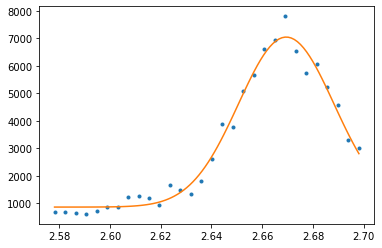

In [582]:
fit, err = scipy.optimize.curve_fit(fit_gaussian_offset, 
                                    z_track_list, 
                                    PL_z_track, 
                                    p0 = (max(PL_z_track)-min(PL_z_track), z0, z_range,min(PL_z_track)))

plot(z_track_list, PL_z_track, '.')
x_curve = linspace(min(z_track_list), max(z_track_list), 100)
plot(x_curve, fit_gaussian_offset(x_curve, *fit),'-')

z_update = fit[1]
task_z = pydaqmx.Task()
task_z.CreateAOVoltageChan("/Dev2/ao0","", 0,5.0,pydaqmx.DAQmx_Val_Volts,None)
task_z.StartTask()
task_z.WriteAnalogScalarF64(1,10.0,z_update,None)
z0=z_update
print('Set z to ', z_update)
task_z.StopTask()

Start time:  2022-03-03 20:52:21.234487
Finish time:  2022-03-03 20:55:22.247468                                      


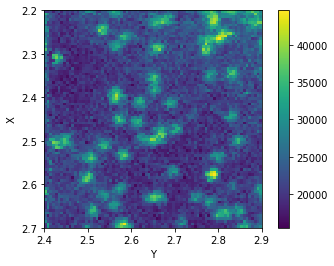

In [89]:
confocal_xy(2.2, 2.7, 80, 2.4, 2.9, 80, 0.01e12)

In [400]:
task_x.StopTask()
task_y.StopTask()
task_z.StopTask()

0

### xyz track

You may need to run this frequently to keep track of the NV center as it could drift over time

In [138]:
x0 = 2.30
x_range = 0.035#0.04
x_steps = 40

y0 = 2.63
y_range = 0.035#0.04
y_steps = 40 

z0 = 2.67
z_range = 0.06
z_steps = 30

In [37]:
time_track = []
x_pos_track = []
y_pos_track = []
z_pos_track = []
PL_track = []

In [191]:
def sweep_xyz(pos0, pos_range, pos_steps, binwidth, task_sweep, counter, label):
    
    pos_list = linspace(pos0-pos_range, pos0+pos_range, pos_steps)
    PL_pos = []
    
    for pos_ao in pos_list:
        task_sweep.WriteAnalogScalarF64(1,10.0,pos_ao,None)

        PL = counter.getData()[0][0]/(binwidth/1e12)
        time.sleep(1.01*binwidth/1e12)
        PL_pos.append(PL)
        status(label+': '+str(pos_ao))
    
    figure()
    xlabel(label)
    plot(pos_list, PL_pos, '.')
    try:
        fit, err = scipy.optimize.curve_fit(fit_gaussian_offset, 
                                            pos_list, PL_pos, 
                                            p0 = (max(PL_pos)-min(PL_pos), pos0, 0.8*pos_range, min(PL_pos)))

        pos_curve = linspace(min(pos_list), max(pos_list), 100)
        plot(pos_curve, fit_gaussian_offset(pos_curve, *fit),'-')

        # update pos to the fitted value
        pos_update = fit[1]
        task_sweep.WriteAnalogScalarF64(1,10.0,pos_update,None)

        print('Set ',label, ' to ', pos_update)

        return fit
    except:
        task_sweep.StopTask()
               

In [90]:
def run_XYZ_track(x0, y0, z0, binwidth = int(1e11)):
    print('X&Y&Z Track:\nStart time: ', datetime.now())
    task_x = pydaqmx.Task()
    task_x.CreateAOVoltageChan("/Dev1/ao0","", 0,5.0,pydaqmx.DAQmx_Val_Volts,None)
    task_x.StartTask()

    task_y = pydaqmx.Task()
    task_y.CreateAOVoltageChan("/Dev1/ao1","", 0,5.0,pydaqmx.DAQmx_Val_Volts,None)
    task_y.StartTask()

    task_z = pydaqmx.Task()
    task_z.CreateAOVoltageChan("/Dev2/ao0","", 0,5.0,pydaqmx.DAQmx_Val_Volts,None)
    task_z.StartTask()
    
    
    pulse_green_on = pulse_designer([0])
    pulse_green_on.add_pulse([0], 1e-6)
    
    configure_pulse = pulse_green_on

    for idxChannel in configure_pulse.channel_list:
        print('configuring channel: %d'%idxChannel)
        Configure_DO_channel(hdwf, idxChannel, array(configure_pulse.pulse[idxChannel]))
    
        # turn on Digital output
    dwf.FDwfDigitalOutConfigure(hdwf, c_int(1))
    
    
#     binwidth = int(1e11)
    n_values = 1

    counter = TimeTagger.Counter(tagger=tagger, channels=[1], binwidth=binwidth, n_values=n_values)
    try:
        # move to the first point for x, and y0 for y
        task_x.WriteAnalogScalarF64(1,10.0, x0-x_range,None)
        task_y.WriteAnalogScalarF64(1,10.0, y0,None)
        task_z.WriteAnalogScalarF64(1,10.0, z0,None)
        time.sleep(0.2)

        x0 = sweep_xyz(x0, x_range, x_steps, binwidth, task_x, counter, 'x')[1]

        task_y.WriteAnalogScalarF64(1,10.0, y0-y_range, None)
        time.sleep(0.1)

        y0 = sweep_xyz(y0, y_range, y_steps, binwidth, task_y, counter, 'y')[1]

        task_z.WriteAnalogScalarF64(1,10.0, z0-z_range, None)
        time.sleep(0.1)

        z_fit = sweep_xyz(z0, z_range, z_steps, binwidth, task_z, counter, 'z')
        z0 = z_fit[1]
    except:
        task_x.StopTask()
        task_y.StopTask()
        task_z.StopTask()
         # turn off Digital output
        dwf.FDwfDigitalOutConfigure(hdwf, c_int(0))
        
        return [0,0,0]
    
    task_x.StopTask()
    task_y.StopTask()
    task_z.StopTask()
     # turn off Digital output
    dwf.FDwfDigitalOutConfigure(hdwf, c_int(0))

    xyz_track_finish_time = datetime.now()
    time_track.append(xyz_track_finish_time)
    x_pos_track.append(x0)
    y_pos_track.append(y0)
    z_pos_track.append(z0)
    PL_track.append(z_fit[0])


    print('Finish time: ', xyz_track_finish_time)
    
    return [x0, y0, z0]

X&Y&Z Track:
Start time:  2022-03-06 14:53:55.600168
Set  x  to  2.317119282980886                                                 
Set  y  to  2.625046331876002                                                 
Set  z  to  2.61679132751844                                                  
Finish time:  2022-03-06 14:54:10.394297


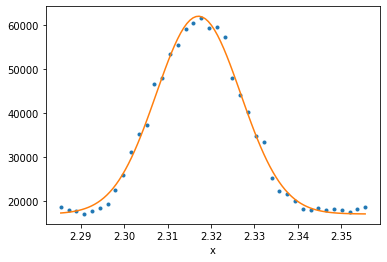

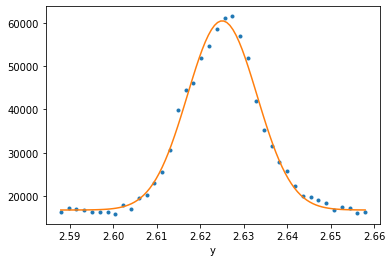

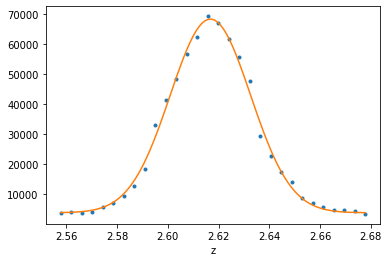

In [60]:
# laser 10 mW
[x0, y0, z0] = run_XYZ_track(x0, y0, z0)

In [57]:
get_count_rate()

38560.0

## MW setting

In [47]:
import pyvisa as visa

In [667]:
rm = visa.ResourceManager()
SRS = rm.open_resource('TCPIP0::169.254.209.144::inst0::INSTR')

In [49]:
def SRSerrCheck(SRS):
    err = SRS.query('LERR?')
    if int(err) is not 0:
        print('SRS error: error code', int(err),'. Please refer to SRS manual for a description of error codes.')
        sys.exit()
    
def enableSRS_RFOutput(SRS):
    SRS.write('ENBR 1')
    SRSerrCheck(SRS)

def disableSRS_RFOutput(SRS):
    SRS.write('ENBR 0')
    SRSerrCheck(SRS)
    
def setSRS_RFAmplitude(SRS,RFamplitude, units='dBm'):
    SRS.write('AMPR '+str(RFamplitude)+' '+units)
    SRSerrCheck(SRS)

def setSRS_Freq(SRS,freq, units='Hz'):
    #setSRSFreq: Sets frequency of the SRS output. You can call this function with one argument only (the first argument, freq),
    # in which case the argument freq must be in Hertz. This function can also be called with both arguments, the first
    # specifying the frequency and the second one specifying the units, as detailed below.
    # arguments: - freq: float setting frequency of SRS. This must either be in Hz if the units argument is not passed.
    #            - units: string describing units (e.g. 'MHz'). For SRS384, minimum unit is 'Hz', max 'GHz'
    SRS.write('FREQ '+str(freq)+' '+units)
    SRSerrCheck(SRS)
    
def enableIQmodulation(SRS):
    SRSerrCheck(SRS)
    #Enable modulation
    SRS.write('MODL 1')
    SRSerrCheck(SRS)
    #Set modulation type to IQ
    SRS.write('TYPE 6')
    SRSerrCheck(SRS)
    #Set IQ modulation function to external
    SRS.write('QFNC 5')
    
def disableModulation(SRS):
    SRS.write('MODL 0')
    SRSerrCheck(SRS)
    
def queryModulationStatus(SRS):
    status = SRS.query('MODL?')
    SRSerrCheck(SRS)
    if status=='1\r\n':
        print('SRS modulation is on...')
        IQstatus = SRS.query('TYPE?')
        SRSerrCheck(SRS)
        if IQstatus=='6\r\n':
            print('...and is set to IQ')
        else:
            print('...but is not set to IQ.')
    else:
        print('SRS modulation is off.')
    return status

## Swabian count for Sig. and Ref. configuration

In [50]:
tagger = TimeTagger.createTimeTagger()

In [194]:
# measure a single frequency n_rep times
n_rep = 500000

In [195]:
sig_counter = TimeTagger.CountBetweenMarkers(tagger=tagger, 
                                             click_channel=1, 
                                             begin_channel=3, 
                                             end_channel=-3, 
                                             n_values= n_rep)

In [196]:
ref_counter = TimeTagger.CountBetweenMarkers(tagger=tagger, 
                                    click_channel=1, 
                                    begin_channel=4, 
                                    end_channel=-4, 
                                    n_values= n_rep)

In [60]:
tagger.setTriggerLevel(channel=3, voltage=0.40)
tagger.setTriggerLevel(channel=4, voltage=0.40)

## ODMR

In [69]:
from datetime import timedelta

In [204]:
# pulse design
odmr2_pulse = pulse_designer(channel_list=[0, 1, 3, 4, 7])
odmr2_pulse.add_pulse([7], 500e-9)
odmr2_pulse.add_pulse([0, 4], 4e-6)
odmr2_pulse.add_pulse([0, 1, 3], 2e-6)

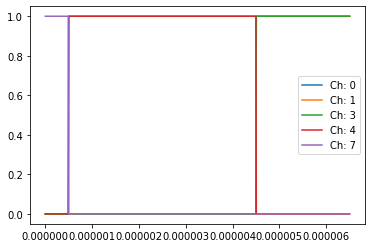

In [205]:
odmr2_pulse.plot_pulse_pattern()

In [206]:
configure_pulse = odmr2_pulse

for idxChannel in configure_pulse.channel_list:
    print('configuring channel: %d'%idxChannel)
    Configure_DO_channel(hdwf, idxChannel, array(configure_pulse.pulse[idxChannel]))

configuring channel: 0
configuring channel: 1
configuring channel: 3
configuring channel: 4
configuring channel: 7


In [95]:
def run_odmr(freq_start, freq_stop, freq_steps):
    freq_list = linspace(freq_start, freq_stop, freq_steps)
    odmr_start_time = datetime.now()
    print('ODMR:\nStart time: ', odmr_start_time)
    sig_list = []
    ref_list = []

    # initialize frequency
    setSRS_Freq(SRS, freq_list[0])
    time.sleep(0.05)
    
    for freq in freq_list:
    
        setSRS_Freq(SRS, freq)

        sig_counter.clear()
        ref_counter.clear()
        time.sleep(0.01)

        # turn on Digital output
        dwf.FDwfDigitalOutConfigure(hdwf, c_int(1))
        
#         sig_counter.waitUntilFinished()
#         ref_counter.waitUntilFinished()
        t_start = datetime.now()
        while sig_counter.ready()==False:
            time.sleep(n_rep_time)
            t_now = datetime.now()
            if t_now-t_start>timedelta(minutes=30):
                print('The experiment is longer than 30 min. Break!')
                break

        sig_list.append(mean(sig_counter.getData()))
        ref_list.append(mean(ref_counter.getData()))

        status('Freq: '+str(round(freq/1e6))+' MHz')
    
    # turn off Digital output
    dwf.FDwfDigitalOutConfigure(hdwf, c_int(0))

    print('Finish time: ', datetime.now())
    return [freq_list, sig_list, ref_list]

X&Y&Z Track:
Start time:  2022-03-06 19:30:57.510770
configuring channel: 0
Set  x  to  2.4406079959703537                                                
Set  y  to  2.7404911763858255                                                
Set  z  to  2.6166454087121087                                                
Finish time:  2022-03-06 19:31:09.567959


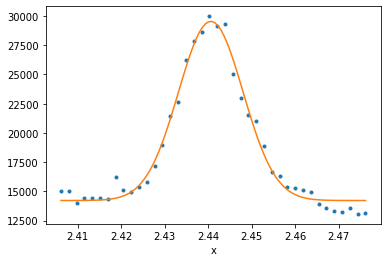

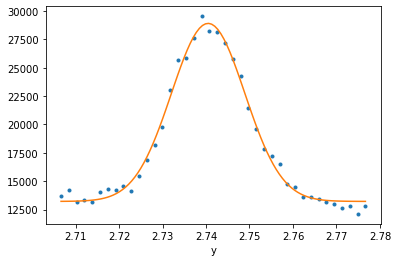

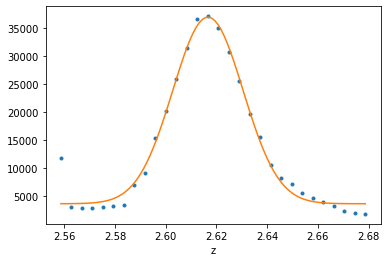

In [207]:
[x0, y0, z0] = run_XYZ_track(x0, y0, z0)

In [208]:
# Set the MW amplitude, unit: dBm
setSRS_RFAmplitude(SRS, -2)

In [209]:
# odmr_2
[freq_list, sig_list, ref_list] = run_odmr(2.83e9, 2.87e9, 20)

ODMR:
Start time:  2022-03-06 19:31:14.318954
Finish time:  2022-03-06 19:33:10.322869                                      


Text(0, 0.5, 'sig/ref')

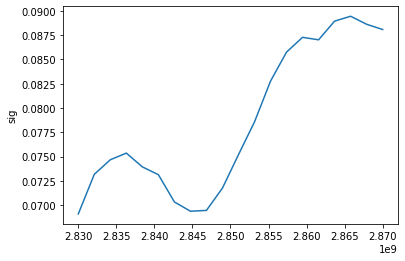

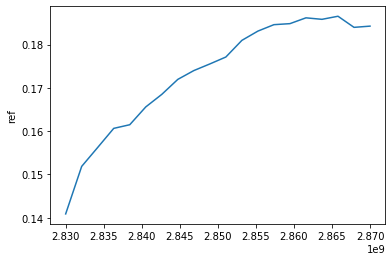

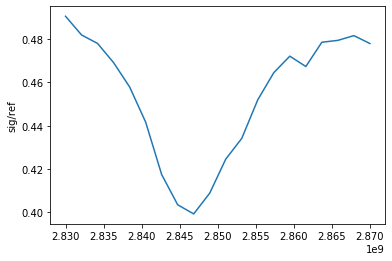

In [210]:
figure()
plot(freq_list, sig_list)
ylabel('sig')
figure()
plot(freq_list, ref_list)
ylabel('ref')
figure()
plot(freq_list, array(sig_list)/array(ref_list))
ylabel('sig/ref')

### fit odmr data

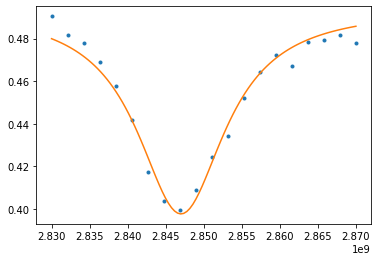

In [211]:
sig_ref = array(sig_list)/array(ref_list)
fit, err = scipy.optimize.curve_fit(fit_lorentzian, 
                                    freq_list, 
                                    sig_ref, 
                                    p0 = (-max(sig_ref)+min(sig_ref), freq_list[argmin(sig_ref)], 0.5*(freq_list[-1]-freq_list[0]), max(sig_ref)))

plot(freq_list, sig_ref, '.')
x_curve = linspace(min(freq_list), max(freq_list), 100)
plot(x_curve, fit_lorentzian(x_curve, *fit),'-')

In [212]:
res_freq = fit[1]
print('Resonant freq: ', round(res_freq/1e6), 'MHz')
setSRS_Freq(SRS, res_freq)

Resonant freq:  2847.0 MHz


### save ODMR data

In [70]:
odmr_save_data_index = 10

In [213]:
# save odmr data
save('data/odmr_%d' % odmr_save_data_index, [freq_list, sig_list, ref_list])

odmr_save_data_index += 1

# Rabi 

In [539]:
def configure_Rabi_pulse(pulsewidth, mw_delay = 50e-9, aom_delay = 850e-9, t_det = 300e-9, t_green = 3000e-9):
    rabi_pulse = pulse_designer(channel_list=[0, 1, 3, 4, 7])
    
    rabi_pulse.add_pulse([7], aom_delay+50e-9) # start
    rabi_pulse.add_pulse([1], pulsewidth) # MW pulse
    rabi_pulse.add_pulse([7], mw_delay) # delay
    rabi_pulse.add_pulse([0], aom_delay) # delay
    rabi_pulse.add_pulse([0, 3], t_det) # signal
    rabi_pulse.add_pulse([0], t_green) # green initialization
    rabi_pulse.add_pulse([0, 4], t_det) # reference
    
    configure_pulse = rabi_pulse

    for idxChannel in configure_pulse.channel_list:
#         print('configuring channel: %d'%idxChannel)
        Configure_DO_channel(hdwf, idxChannel, array(configure_pulse.pulse[idxChannel]))
        
    return configure_pulse.get_total_length()

In [664]:
pulsewidth_start = 0
pulsewidth_stop = 500e-9
pulsewidth_steps = 20

pulsewidth_list = linspace(pulsewidth_start, pulsewidth_stop, pulsewidth_steps)
pulsewidth_stepsize = pulsewidth_list[1] - pulsewidth_list[0]
if pulsewidth_stepsize<10e-9:
    print('Stepsize is below digital output resolution (10 ns)!')

In [665]:
# Configure Swabian
tagger = TimeTagger.createTimeTagger()

# measure a single point n_rep times
n_rep = 2000000

sig_rabi_counter = TimeTagger.CountBetweenMarkers(tagger=tagger, 
                                             click_channel=1, 
                                             begin_channel=3, 
                                             end_channel=-3, 
                                             n_values= n_rep)

ref_rabi_counter = TimeTagger.CountBetweenMarkers(tagger=tagger, 
                                             click_channel=1, 
                                             begin_channel=4, 
                                             end_channel=-4, 
                                             n_values= n_rep)


In [668]:
# Configure MW source
MW_amp = 9

# Set the MW amplitude, unit: dBm
setSRS_RFAmplitude(SRS, MW_amp)

In [669]:
tagger.setTriggerLevel(channel=3, voltage=0.40)
tagger.setTriggerLevel(channel=4, voltage=0.40)

In [549]:
# aom_delay = 0
rabi_start_time = datetime.now()
print('Rabi:\nStart time: ', rabi_start_time)

sig_rabi_list = []
ref_rabi_list = []


for pulsewidth in pulsewidth_list:
    total_length = configure_Rabi_pulse(pulsewidth, mw_delay = 50e-9, aom_delay = 920e-9, t_det = 300e-9, t_green = 3000e-9)
    
    n_rep_time = total_length * n_rep
    sig_rabi_counter.clear()
    ref_rabi_counter.clear()
    time.sleep(0.01)
    
    # turn on Digital output
    dwf.FDwfDigitalOutConfigure(hdwf, c_int(1))
    
    t_start = datetime.now()
    while sig_rabi_counter.ready()==False:
        time.sleep(n_rep_time)
        t_now = datetime.now()
        if t_now-t_start>timedelta(minutes=30):
            print('The experiment is longer than 30 min. Break!')
            break
    
    sig_rabi_list.append(mean(sig_rabi_counter.getData()))
    ref_rabi_list.append(mean(ref_rabi_counter.getData()))
    
    status('Pulsewidth: '+str(round(pulsewidth*1e9))+' ns')

# turn off Digital output
dwf.FDwfDigitalOutConfigure(hdwf, c_int(0))

print('Finish time: ', datetime.now())

Rabi:
Start time:  2022-03-06 21:24:05.805649
Finish time:  2022-03-06 21:31:36.901759                                      


Text(0, 0.5, 'sig_rabi/ref_rabi')

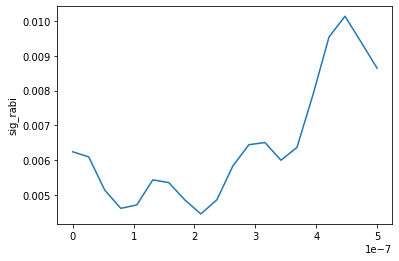

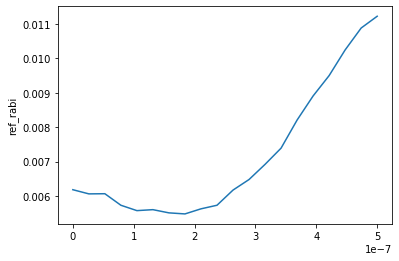

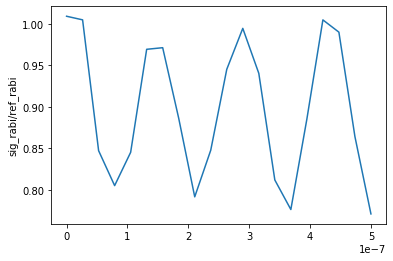

In [550]:
figure()
plot(pulsewidth_list, sig_rabi_list)
ylabel('sig_rabi')

figure()
plot(pulsewidth_list, ref_rabi_list)
ylabel('ref_rabi')

rabi_data = array(sig_rabi_list)/array(ref_rabi_list)
figure()
plot(pulsewidth_list, rabi_data)
ylabel('sig_rabi/ref_rabi')


### save Rabi data

In [229]:
rabi_save_data_index = 0

In [423]:
# save rabi data
save('data/rabi_%d' % rabi_save_data_index, [pulsewidth_list, sig_rabi_list, ref_rabi_list])

rabi_save_data_index += 1

# correlation 

In [598]:
correlation = TimeTagger.Correlation(tagger=tagger, channel_1=1, channel_2=2, binwidth=1000, n_bins=200)

Text(0, 0.5, 'Incidence')

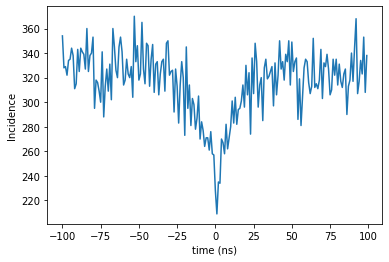

In [619]:
plot(correlation.getIndex()/1e3, correlation.getData())
xlabel('time (ns)')
ylabel('Incidence')

Text(0, 0.5, 'g(2)')

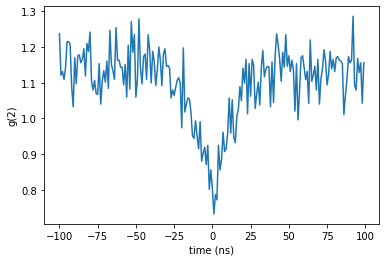

In [621]:
plot(correlation.getIndex()/1e3, correlation.getDataNormalized())
xlabel('time (ns)')
ylabel('g(2)')

## turn off the connections to the devices 

In [674]:
dwf.FDwfDigitalOutReset(hdwf)
dwf.FDwfDeviceCloseAll()

1

In [675]:
    TimeTagger.freeTimeTagger(tagger)

True